<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteT8FG04/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteT8FG04/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


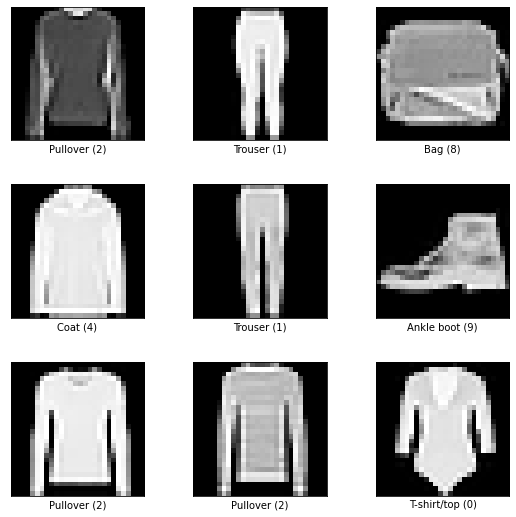

In [2]:
ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)

In [3]:
batch_size = 128
image_shape = (32, 32, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])    
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size, drop_remainder=True)

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

469


In [4]:
def generator(z_dim):
    
    DIM=128
    model = tf.keras.Sequential(name='Generator') 

    model.add(layers.Dense(4*4*4*DIM))
    model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())
    model.add(layers.Reshape((4,4,4*DIM))) 

    model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
    model.add(layers.Conv2D(2*DIM, 5, padding='same')) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())

    model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
    model.add(layers.Conv2D(DIM, 5, padding='same')) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())

    model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))       
    model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')) 

    return model    

In [5]:
def discriminator(image_shape):
    DIM = 128
    model = tf.keras.Sequential(name='critics') 

    model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
    model.add(layers.LeakyReLU(0.2))


    model.add(layers.Flatten()) 
    model.add(layers.Dense(1)) 

    return model

In [6]:
class WGAN(Model):

    def __init__(self, z_dim, image_shape, n_critic=5, penalty_const=10.0):
        super(WGAN, self).__init__()

        self.generator = generator(z_dim)
        self.discriminator = discriminator(image_shape)

        self.n_critic = 5
        self.z_dim = z_dim
        self.penalty_const = penalty_const
    
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn):
        super(WGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
    

    def train_step(self, real_imgs):

        batch_size = tf.shape(real_imgs)[0]

        random_noise = tf.random.normal((batch_size, self.z_dim))
        fake_imgs = self.generator(random_noise)

        for _ in range(self.n_critic):
            d_loss = self.train_critic(real_imgs, fake_imgs, batch_size)

        with tf.GradientTape() as g_tape:

            z = tf.random.normal((batch_size, self.z_dim))
            fake_imgs = self.generator(z)
            fake_preds = self.discriminator(fake_imgs)

            g_loss = self.g_loss_fn(fake_preds)
        
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {'g_loss': g_loss, 'd_loss': d_loss}

    def train_critic(self, real_imgs, fake_imgs, batch_size):
        
        with tf.GradientTape() as gp_tape, tf.GradientTape() as d_tape:
            
            fake_pred = self.discriminator(fake_imgs)
            real_pred = self.discriminator(real_imgs)

            d_cost = self.d_loss_fn(fake_pred, real_pred)

            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon * fake_imgs + (1-epsilon)*real_imgs

            gp_tape.watch(interpolates)
            critic_interpolates = self.discriminator(interpolates)

            gp_grads = gp_tape.gradient(critic_interpolates, [interpolates])

            l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_grads), axis=[1, 2, 3]))

            gp = tf.reduce_mean((l2_norm - 1) ** 2)

            d_loss = d_cost + self.penalty_const * gp
        
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        return d_loss
    
    def call(self, num_imgs):
        z = tf.random.normal((num_imgs, self.z_dim))
        return self.generator(z)

In [7]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, num_imgs=5, interval=5):
        super(GenerativeCallback, self).__init__()
        
        self.num_imgs = num_imgs
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % self.interval) is not 0:
            return 
        grid_row = 1
        grid_col = self.num_imgs
        images = self.model(self.num_imgs)
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col,:,:,0]+1)*127.5, cmap='gray')
            axarr[col].axis('off') 
        plt.show()

In [8]:
def g_loss_fn(fake_pred):
    return -tf.reduce_mean(fake_pred)

def d_loss_fn(fake_pred, real_pred):
    return tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred)

generator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

Epoch 1/10
  6/468 [..............................] - ETA: 5:55 - g_loss: 0.8559 - d_loss: -1.6409WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1482s vs `on_train_batch_end` time: 0.5180s). Check your callbacks.


468/468 [==============================] - 433s 848ms/step - g_loss: 0.7920 - d_loss: -1.3974


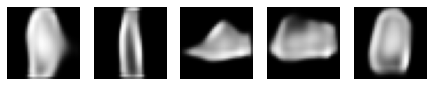

Epoch 2/10
468/468 [==============================] - 404s 859ms/step - g_loss: 0.0861 - d_loss: -0.5362


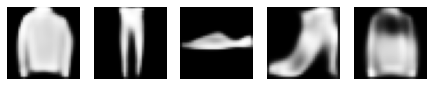

Epoch 3/10
468/468 [==============================] - 405s 861ms/step - g_loss: 0.0636 - d_loss: -0.4546


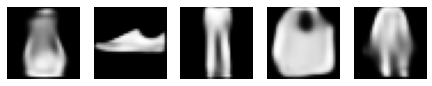

Epoch 4/10
468/468 [==============================] - 404s 859ms/step - g_loss: 0.0460 - d_loss: -0.4147


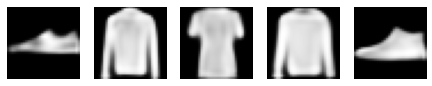

Epoch 5/10
468/468 [==============================] - 404s 859ms/step - g_loss: 0.0491 - d_loss: -0.3880


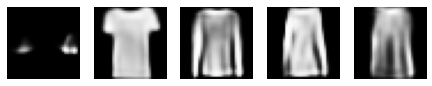

Epoch 6/10
468/468 [==============================] - 404s 859ms/step - g_loss: 0.0451 - d_loss: -0.3708


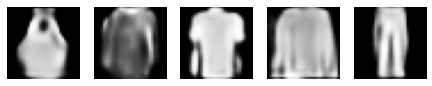

Epoch 7/10
468/468 [==============================] - 403s 858ms/step - g_loss: 0.0496 - d_loss: -0.3583


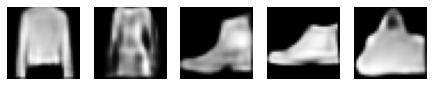

Epoch 8/10
468/468 [==============================] - 404s 859ms/step - g_loss: 0.0417 - d_loss: -0.3476


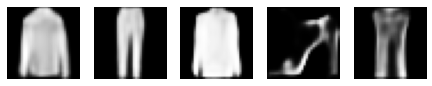

Epoch 9/10
468/468 [==============================] - 404s 860ms/step - g_loss: 0.0434 - d_loss: -0.3416


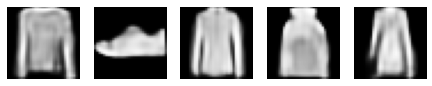

Epoch 10/10
468/468 [==============================] - 404s 859ms/step - g_loss: 0.0438 - d_loss: -0.3380


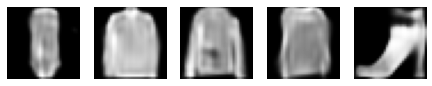

In [9]:
wgan_gp = WGAN(128, image_shape)

wgan_gp.compile(
    generator_optimizer,
    discriminator_optimizer,
    g_loss_fn,
    d_loss_fn
)

callbacks = [GenerativeCallback(interval=1)]

wgan_gp.fit(ds_train, epochs=10, callbacks=callbacks)